<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Longformer </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px">

- Input Embeddings: The first stage of the Longformer architecture is represented by the Input Embeddings section. The input tokens are represented by the Input Tokens node, and their transformation into numerical embeddings is shown by the Embeddings node. These embeddings record the input tokens' semantic and contextual details.<br><br>
- Encoder Layers: The Encoder Layer 1 and Encoder Layer 2 nodes show that the Encoder Layers section contains multiple encoder layers. As required, further encoder layers can be implemented. The input embeddings are processed successively by these encoder layers, which also record the input sequence's hierarchical representations.<br><br>
- Self-Attention Mechanism: The relationships between various tokens in the input sequence are recorded in the Self-Attention section. The self-attention mechanism, which attends to all tokens and detects global dependencies, is represented by the Self-Attention node. The global attention mechanism and the local attention mechanism, respectively, are represented by the Global Attention and Local Attention nodes in the Self-Attention section. The model can effectively handle long-range dependencies because the global attention allows each token to attend to all other tokens while the local attention concentrates on a portion of nearby tokens.<br><br>
- Feed-Forward Neural Network: The output of the self-attention mechanism is processed in the Feed-Forward Neural Network portion, which is represented by the Feed-Forward NN node. The token representations are subjected to non-linear transformations, enabling the recording of more intricate relationships.<br><br>
- Residual Connections and Layer Normalization: The model's training stability and information flow are improved by the Residual Connections and Layer Normalisation part. The connections that transfer the output of one encoder layer directly to succeeding levels are identified by the Residual Connections node. As a result, lower-level token representations are preserved throughout training. The representations following each sub-layer are normalised by the Layer Normalisation node, which aids in the entire training process.<br><br>
- Output Layers: The Output Layers section denotes the Longformer architecture's last phase. The model's output, denoted by the Output node, can be applied to a variety of downstream tasks, including categorization, question answering, and summarization.<br><br>
The information and computation flow is represented by the links between the nodes. As an illustration, the input tokens pass via the input embeddings before being successively processed by the encoder layers. The feed-forward neural network receives the output from the encoder layers after passing it through the self-attention mechanism. The output of the feed-forward neural network then passes through layer normalisation, residual connections, and the output layer.<br><br>
Different elements of the Longformer architecture are designed to be visually distinguished using the colours used in the diagram. Each element has its own colour scheme, making it simpler to recognise and understand the diagram's components.<br><br></div>


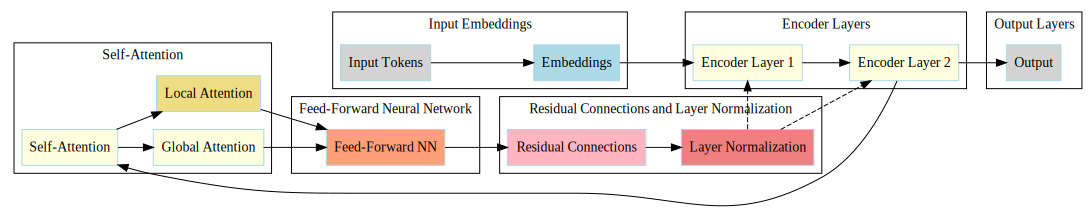

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/longformer.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Importing modules
    </div>

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting random seed for reproducibility    </div>

In [3]:
torch.manual_seed(42)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Reading dataframe and inspecting their columns    </div>

In [4]:
train_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')


In [5]:
train_df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [6]:
test_df.columns

Index(['id', 'comment_text'], dtype='object')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Preparing data for training    </div>

In [7]:
train_texts = train_df['comment_text'].tolist()
train_labels = train_df['target'].astype(float).tolist()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Splitting the data into train and val sets. Here, we intentionally chunked the text samples to 100, feel free to remove it for complete training.    </div>

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts[:100], train_labels[:100], test_size=0.2, random_state=42)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Tokenizing the texts    </div>

In [9]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=4096)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=4096)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating dataset class    </div>

In [10]:
class ToxicityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating train and val dataset    </div>

In [11]:
train_dataset = ToxicityDataset(train_encodings, train_labels)
val_dataset = ToxicityDataset(val_encodings, val_labels)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating train and val dataloaders and inspecting them    </div>

In [12]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [13]:
for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[    0,  2387,  1203,    12,   658,    95,   122,  1705,    75,    33,
            57, 31675,   328,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Loading the longformer model    </div>

In [14]:
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096')


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', '

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting device to GPU and moving model to it.    </div>

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting optimizer and learning rate    </div>

In [16]:
optimizer = AdamW(model.parameters(), lr=1e-5)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Putting model to train and val.    </div>

In [19]:
# Training loop
model.train()
num_epochs = 3
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).repeat(1, 2).to(device)  # Adjust the shape of labels
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for batch in val_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).repeat(1, 2).to(device)  # Adjust the shape of labels
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}: Train Loss = {train_loss}, Val Loss = {val_loss}')


Epoch 1: Train Loss = 0.4916120771318674, Val Loss = 0.38194221034646036
Epoch 2: Train Loss = 0.2907418064773083, Val Loss = 0.3769370909780264
Epoch 3: Train Loss = 0.24229335533455015, Val Loss = 0.2917042512446642


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Inferencing to generate submission    </div>

In [23]:
from tqdm import tqdm
# Test the model on the test set
test_texts = test_df['comment_text'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=4096)
test_dataset = ToxicityDataset(test_encodings, [0] * len(test_encodings))  # Placeholder labels
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

model.eval()
predictions = []
for batch in tqdm(test_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.sigmoid(logits).cpu().numpy().flatten().tolist()
        predictions.extend(batch_predictions)


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generating submission    </div>

In [26]:
# Generate submission file
submission_df = pd.DataFrame({'id': test_df['id'][:4], 'prediction': predictions})
submission_df.to_csv('submission.csv', index=False)

In [27]:
submission_df

,id,prediction
0,7097320,0.104767
1,7097321,0.112205
2,7097322,0.092554
3,7097323,0.102792
